# HDI Reduction Benchmarking Notebook
### Week of 2.1.2018

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

from astropy.stats import sigma_clipping
import time



### Step 0: Make Defintions


In [2]:

# 
# change these if you'd like to run this
#

indir = '/Volumes/A341/ObservingRunData/20180115/'



reducedir = indir+'reduced/'



In [3]:
def find_files(directory,img_type,filternum=-1):
    #
    # definition to go through HDI headers and get the images desired of a particular type
    #    and filter
    #
    
    #
    # limitations:
    #    - not set up to sort by specific targets
    #    - will not enforce one of the filter wheel slots being empty
    # 
    
    # grab all HDI files from the specified directory
    files = [infile for infile in glob.glob(directory+'c*t*fits') if not os.path.isdir(infile)]
    
    out_files = []

    for f in files:
        #print(f)
        phdr = fits.getheader(f,0) # the 0 is needed to get the correct extension
    
        # filter by desired_type
        
        # if biases, don't care about filter
        if    (img_type == phdr['OBSTYPE']) \
            & (img_type == 'BIAS'):
                    
            out_files.append(f)
            
        # if flats or objects, the filter matters
        if    (img_type == phdr['OBSTYPE']) \
            & (img_type != 'BIAS')\
            & ( (str(filternum) == phdr['FILTER1']) | (str(filternum) == phdr['FILTER2']) ):

            out_files.append(f)


    return out_files




def arrange_quadrants(quadrants):
    '''
    rearrange HDI quadrants to be in the proper configuration
    
    '''
    
    saxis_x,saxis_y = quadrants[0].shape
    data_array = np.zeros([2*saxis_x,2*saxis_y])

    # reposition different segments
    data_array[0:saxis_x        ,0:saxis_y]         = quadrants[0]            # lower left
    data_array[0:saxis_x        ,saxis_y:2*saxis_y] = quadrants[1][:,::-1]    # lower right
    data_array[saxis_x:2*saxis_x,0:saxis_y]         = quadrants[2][::-1,:]    # upper left
    data_array[saxis_x:2*saxis_x,saxis_y:2*saxis_y] = quadrants[3][::-1,::-1] # upper right

    # include the left-right flip
    return data_array[::-1,:]



def read_image(infile,mosaic=True):
    '''
    
    read in an image and either return
    
    mosaic==True
        single mosaicked, non-overscan frame
        
    mosaic==False
        dictionary of numbered quadrants for overscan operations
        
        (can later be combined with arrange_quadrants)

    '''
    
    ofile = fits.open(infile)

    # retreive header for the purposes of sizing the array
    phdr = fits.getheader(infile,0)

    saxis_x = int(phdr['CNAXIS2'])
    saxis_y = int(phdr['CNAXIS1'])+int(phdr['OVRSCAN1'])
        
    # overscan array is solely the overscan region of each quadrant
    overscan_quad = {}
        
    # median_array is the entire array, overscan included
    data_quad = {}
    
    for ext in range(1,5):
        overscan_quad[ext-1] = ofile[ext].data[0:saxis_x,phdr['CNAXIS1']:saxis_y]
        data_quad[ext-1] = ofile[ext].data[0:saxis_x,0:phdr['CNAXIS1']]
        
        
    if mosaic:
        data_mosaic = arrange_quadrants(data_quad)
        
        return data_mosaic,overscan_quad
    
    else:
        return data_quad,overscan_quad
        



# Biases.

In [4]:

# check out the biases
bias_files = find_files(indir,'BIAS')
print('N_BIASES: ',len(bias_files))



N_BIASES:  16


In [5]:
# test reading files

# use this number to increase statistical certainty
nreads = 200

t1 = time.time()


for imgnum in range(0,nreads):
    
    ofile = fits.open(bias_files[0])
    
    for ext in range(1,5):
        setval = ofile[ext].data
        
    # naively, I assumed closing the file would save memory allocation, but it doesn't.
    #ofile.close()


print('time elapsed per read:',np.round((time.time()-t1)/float(nreads),3),' seconds')




time elapsed per read: 0.079  seconds


Benchmarks:
1. Mike's Computer+Samsung EVO: time elapsed per read: 0.086  seconds

In [6]:

ltimes = []

for nfiles in range(2,len(bias_files)):
    
    use_bias = bias_files[0:nfiles]
    t1 = time.time()
    data = np.zeros([len(use_bias),4112,4096])


    for imgnum,img in enumerate(use_bias):
        data[imgnum],ovrscn = read_image(img)
        
        # check the levels in each bias quadrant:
        
        #data,ovrscn = read_image(img,mosaic=False)
        #print([np.median(ovrscn[x])-np.median(datareg[x]) for x in range(0,4)])

    masterbias = np.median(data,axis=0)

    print('time elapsed to median ({0} files):'.format(nfiles),np.round(time.time()-t1,2),' seconds')
    ltimes.append(np.round(time.time()-t1,2))


phdr = fits.getheader(bias_files[0],0)

fits.writeto(reducedir+'masterbias.fits',masterbias,phdr,clobber=True)

print('time elapsed total:',np.round(time.time()-t1,2),' seconds')



time elapsed to median (2 files): 1.85  seconds
time elapsed to median (3 files): 2.21  seconds
time elapsed to median (4 files): 3.15  seconds
time elapsed to median (5 files): 3.48  seconds
time elapsed to median (6 files): 4.57  seconds
time elapsed to median (7 files): 4.79  seconds
time elapsed to median (8 files): 5.69  seconds
time elapsed to median (9 files): 6.0  seconds
time elapsed to median (10 files): 7.01  seconds
time elapsed to median (11 files): 7.31  seconds
time elapsed to median (12 files): 8.34  seconds
time elapsed to median (13 files): 8.75  seconds
time elapsed to median (14 files): 9.56  seconds
time elapsed to median (15 files): 9.94  seconds
time elapsed total: 15.09  seconds


Benchmark runs:

time elapsed total: 19.47  seconds

Plus see benchmarking plot below. Gray is Mike's computer benchmark.

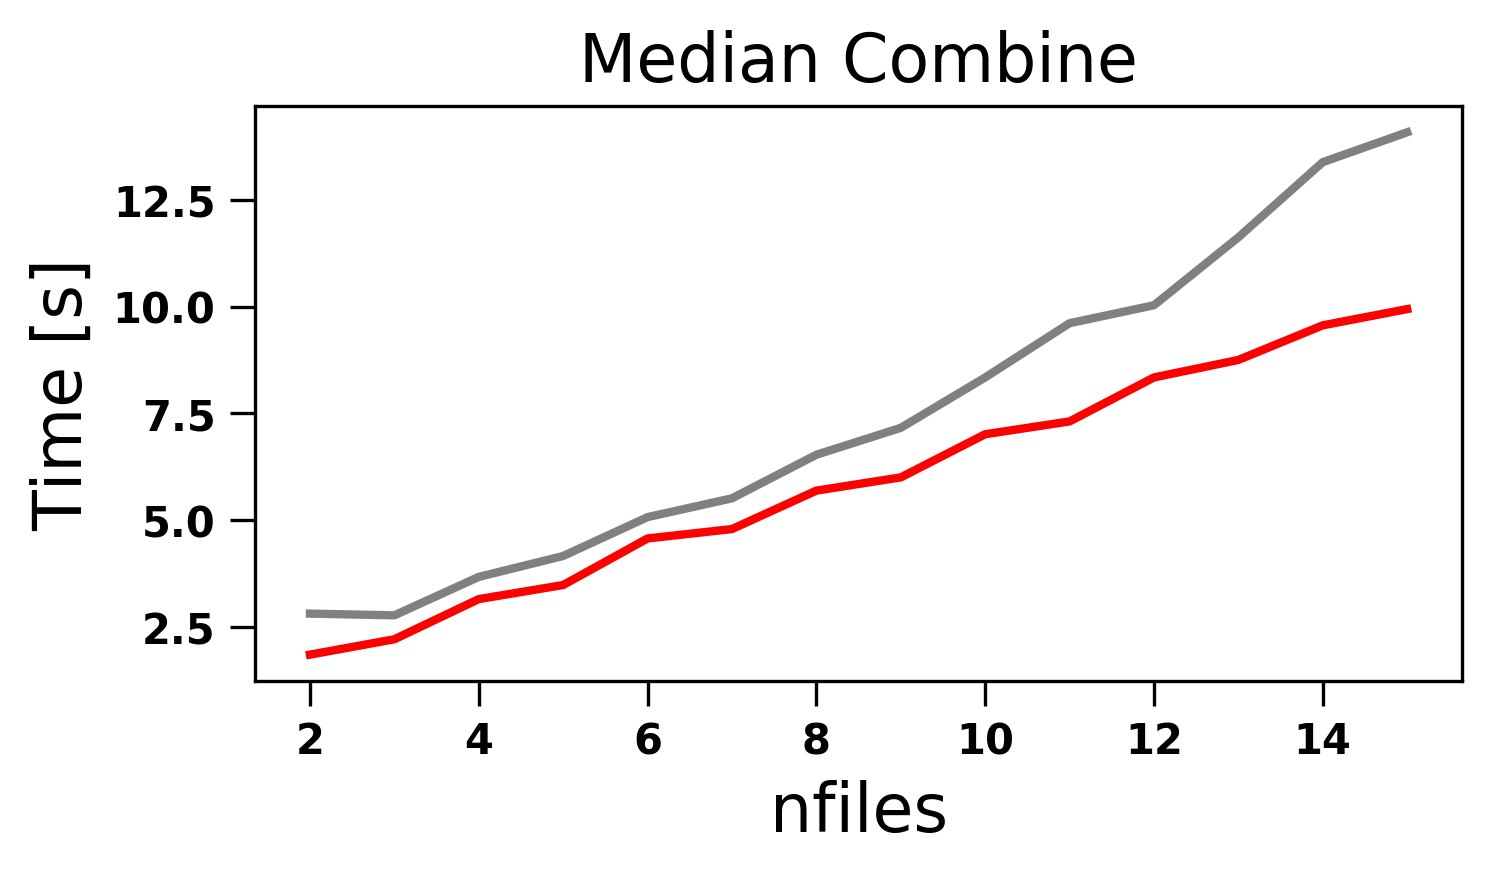

In [7]:
filenums = np.arange(2,len(bias_files),1)

benchtimes = [2.81,2.77,3.67,4.16,5.07,5.51,6.53,7.16,8.34, 9.61, 10.03,11.62,13.38,14.08]

plt.figure(figsize=(5,3))
plt.plot(filenums,benchtimes,color='gray')
plt.plot(filenums,np.array(ltimes),color='red')
plt.title('Median Combine',size=16)
plt.ylabel('Time [s]',size=16)
plt.xlabel('nfiles',size=16)
plt.tight_layout()

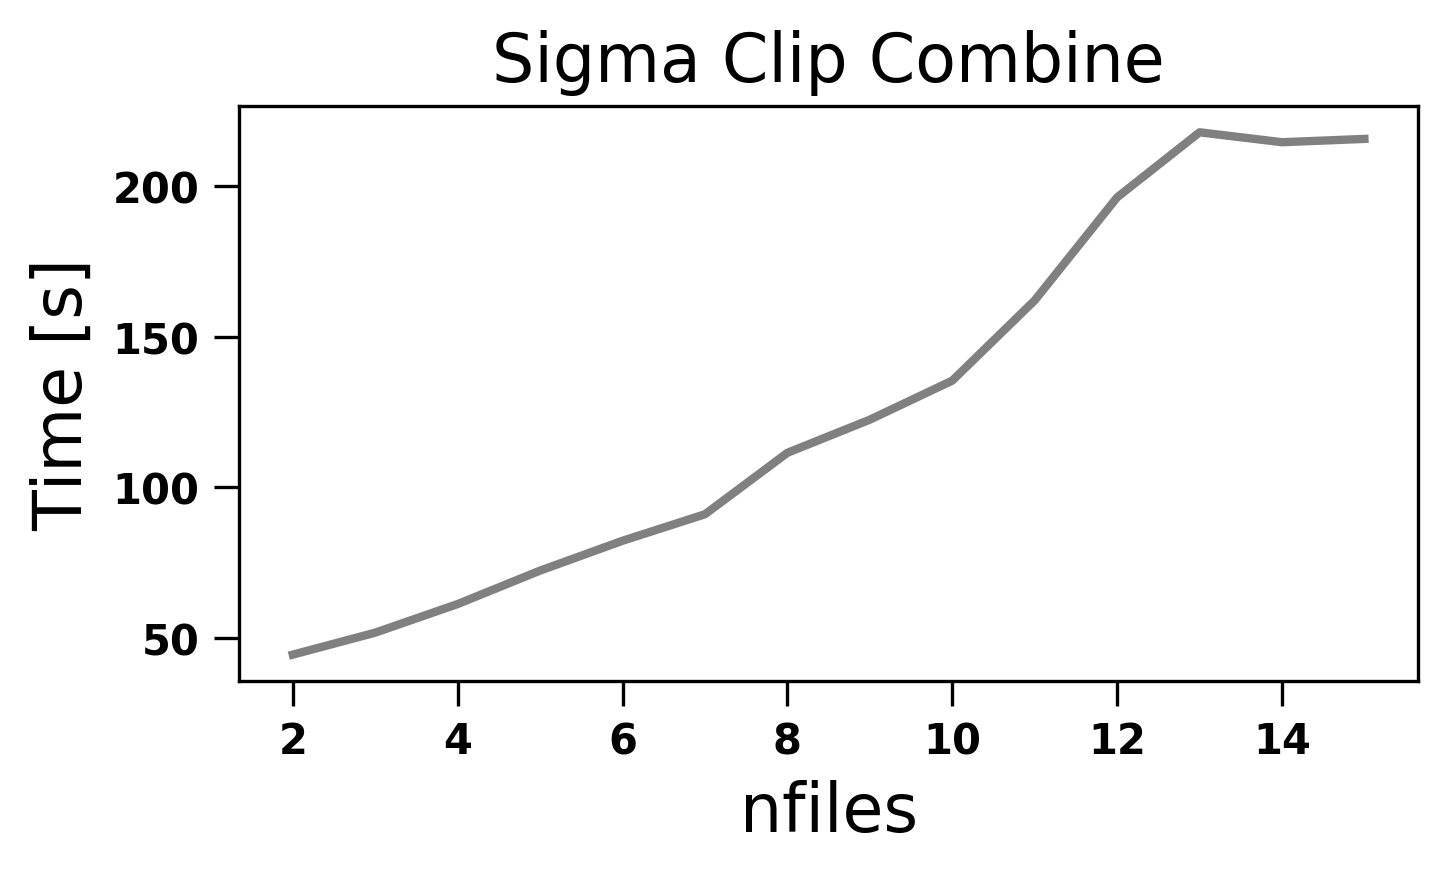

In [8]:
filenums = np.arange(2,len(bias_files),1)

benchtimes = [44.5,51.8,61.3,72.4,82.3,91.1,111.5,122.5,135.46,162.1,196.3,217.9,214.6,215.7]

plt.figure(figsize=(5,3))
plt.plot(filenums,benchtimes,color='gray')

# if checking against data from above, uncomment this
#plt.plot(filenums,np.array(ltimes),color='red')

plt.title('Sigma Clip Combine',size=16)
plt.ylabel('Time [s]',size=16)
plt.xlabel('nfiles',size=16)
plt.tight_layout()

In [9]:
# test writing files

# MUST HAVE MASTERBIAS DEFINED: to be run sequentially with above cells

nreads = 10

t1 = time.time()

phdr = fits.getheader(bias_files[0],0)


for imgnum in range(0,nreads):
    fits.writeto(reducedir+'masterbias.fits',masterbias,phdr,clobber=True)

print('time elapsed per write:',np.round((time.time()-t1)/float(nreads),3),' seconds')






time elapsed per write: 8.879  seconds


Benchmark:

1. time elapsed per write: 4.32  seconds

Theoretical maximum is 100 MB/s...how did we do?